# Exercise in statistics

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math
import io 

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('bmh')

import plotly.express as px

from pylab import rcParams
from google.colab import files

%config InlineBackend.figure_format = 'svg'

**GeneralPopulation class**  
Already has methods for creating general population as a mixture of strata, for generating subsample with random, optimal and stratified techniques:

In [ ]:
class GeneralPopulation:

  def __init__(self, 
               means: [float], 
               stds: [float], 
               sizes: [int], 
               random_state: int = 15
               ):
    """
    Initializes our General Population and saves the given distributions
    
    :param means: List of expectations for normal distributions
    :param stds: List of standard deviations for normal distributions
    :param sizes: How many objects will be in each strata
    :param random_state: Parameter fixing randomness. Needed so that when conducting
    experiment repeatedly with the same input parameters, the results remained the same
    """
    self.strats = [st.norm(mean, std) for mean, std in zip(means, stds)]
    self._sample(sizes)
    self.random_state = random_state

  def _sample(self, sizes):
        """Creates a general population sample as a mixture of strata
        
        :param sizes: List with sample sizes of the corresponding normal distributions
        """
        self.strats_samples = [rv.rvs(size) for rv, size in zip(self.strats, sizes)]
        self.general_samples = np.hstack(self.strats_samples)
        self.N = self.general_samples.shape[0]
        
        # number of strata
        self.count_strats = len(sizes)
        
        # ratios for every strata in GP
        self.ws = [size/self.N for size in sizes]
        
        # ME and Std for GP
        self.m = np.mean(self.general_samples)
        self.sigma = np.std(self.general_samples)
        
        # ME and std for all strata
        self.ms = [np.mean(strat_sample) for strat_sample in self.strats_samples]
        self.sigmas = [np.std(strat_sample) for strat_sample in self.strats_samples]

  def random_subsampling(self, size):
      """Creates a random subset of the entire population
      
      :param sizes: subsample size
      """
      rc = np.random.choice(self.general_samples, size=size) 
      return rc
      
  def proportional_subsampling(self, size):
      """Creates a subsample with the number of elements, proportional shares of strata
      
      :param sizes: subsample size
      """
      self.strats_size_proport = [int(np.floor(size*w)) for w in self.ws]
      
      rc = []
      for k in range(len(self.strats_size_proport)):
          rc.append(np.random.choice(self.strats_samples[k],
                                      size=self.strats_size_proport[k]))
      
      return rc
      
  def optimal_subsampling(self, size):
      """Creates a subsample with the optimal number of elements relative to strata
      
      :param sizes: subsample size
      """
      sum_denom = 0
      for k in range(self.count_strats):
          sum_denom += self.ws[k] * self.sigmas[k]
      
      self.strats_size_optimal = [int(np.floor((size*w*sigma)/sum_denom)) for w, sigma in zip(self.ws, self.sigmas)]
      if 0 in self.strats_size_optimal:
          raise ValueError('Strats size is 0, please change variance of smallest strat!')
      
      rc = []
      for k in range(len(self.strats_size_optimal)):
          rc.append(np.random.choice(self.strats_samples[k],
                                      size=self.strats_size_optimal[k]))
      
      return rc   

  def run_experiments(self, n_sub, subsampling_method, n_experiments=1000):
      """Conducts a series of experiments and saves the results
      
      :param subsampling_method: method for creating a subsample
      :param n_experiments: number of experiment starts
      """
      means_s = []
      
      if(len(self.general_samples)<100):
          n_sub = 20
      
      if(subsampling_method == 'random_subsampling'):
          for n in range(n_experiments):
              rc = self.random_subsampling(n_sub)
              
              mean = rc.sum()/len(rc)
              means_s.append(mean)
              
      else:
          for n in range(n_experiments):
              if(subsampling_method == 'proportional_subsampling'):
                  rc = self.proportional_subsampling(n_sub)
              elif(subsampling_method == 'optimal_subsampling'):
                  rc = self.optimal_subsampling(n_sub)
              
              strats_mean = []
      
              for k in range(len(rc)):
                  strats_mean.append(sum(rc[k])/len(rc[k]))
      
              # Mean for a mixture
              means_s.append(sum([w_k*mean_k for w_k, mean_k in zip(self.ws, strats_mean)]))
              
      return means_s

Function for histogram plot:

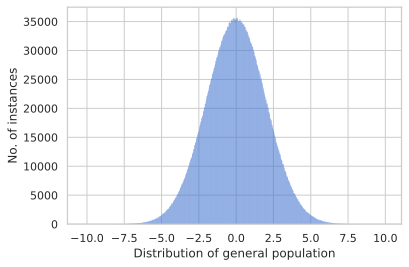

In [ ]:

sns.set_theme(style='whitegrid', palette='muted')
x = GeneralPopulation(means = [0, 0, 0], 
               stds = [2, 2, 2],
               sizes = [1000000, 2000000, 3000000],  
               random_state = 21)

hist1 = sns.histplot(x.general_samples)

hist1.set(xlabel='Distribution of general population', ylabel ='No. of instances', )
plt.show()

Function for plotting Boxplots for sample mean:

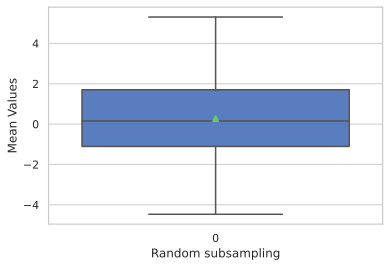

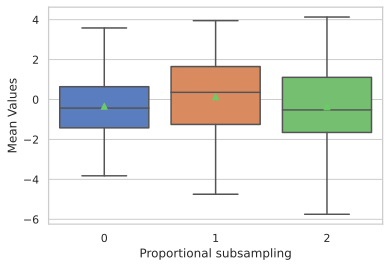

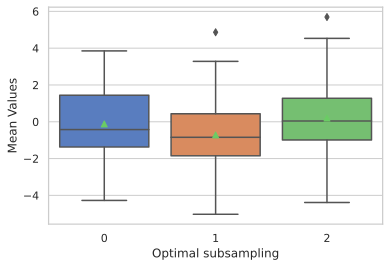

In [ ]:
x = GeneralPopulation(means = [0, 0, 0], 
               stds = [2, 2, 2],
               sizes = [100000, 200000, 300000],  
               random_state = 21)

rdm = x.random_subsampling(size = 200)
prp = x.proportional_subsampling(size = 200)
opt = x.optimal_subsampling(size = 200)


plot1 = sns.boxplot(data = rdm, showmeans = True)
plot1.set(xlabel='Random subsampling', ylabel ='Mean Values')
plt.show()
plot2 = sns.boxplot(data = prp, showmeans = True)
plot2.set(xlabel='Proportional subsampling', ylabel ='Mean Values')
plt.show()
plot3 = sns.boxplot(data = opt, showmeans = True)
plot3.set(xlabel='Optimal subsampling', ylabel ='Mean Values')
plt.show()



Random sampling seems to have done an alright job in this case. We can see that there is some mismatch with real values in both proportional and optimal methods here, though both are in the ballpark with optimal doing better

**Parameters for each General Population**  
You can use these or specify your own parameters for strata:

In [ ]:
SIZES = (150, 150, 150)
N_SUBSAMPLE = 150
EQUAL_MEAN_EQUAL_STDS_ARGS = {'means': [0, 0, 0], 'stds': [3, 3, 3], 'sizes': SIZES}
DIFFERENT_MEAN_EQUAL_STDS_ARGS = {'means': [15, -1, -17], 'stds': [3, 3, 3], 'sizes':SIZES}
EQUAL_MEAN_DIFFERENT_STDS_ARGS = {'means': [0, 0, 0], 'stds': [3, 7, 11], 'sizes':SIZES}


{'means': [0, 0, 0], 'stds': [3, 3, 3], 'sizes': (150, 150, 150)}


**Initialization**

In [ ]:
# Create GeneralPopulation class instances here
emesa = GeneralPopulation(means= [0, 0, 0], stds= [3, 3, 3], sizes= (150, 150, 150))
dmesa = GeneralPopulation(means= [15, -1, -17], stds= [3, 3, 3], sizes= (150, 150, 150))
emdsa = GeneralPopulation(means= [0, 0, 0], stds= [3, 7, 11], sizes= (150, 150, 150))

**General population with EQUAL means and EQUAL STDs of strata**  
Distribution histogram:

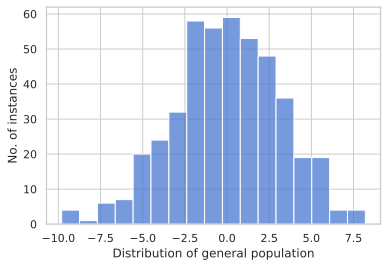

In [ ]:
hist = sns.histplot(emesa.general_samples)

hist.set(xlabel='Distribution of general population', ylabel ='No. of instances', )
plt.show()

Boxplots for sample mean:

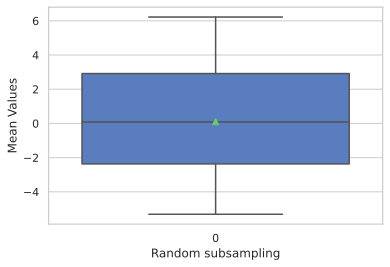

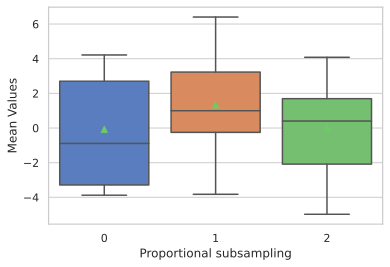

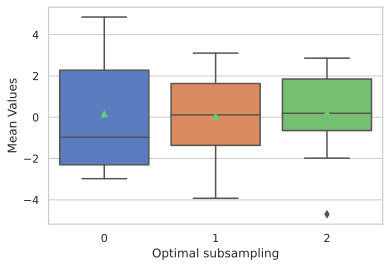

In [ ]:
rdm = emesa.random_subsampling(size = 40)
prp = emesa.proportional_subsampling(size = 40)
opt = emesa.optimal_subsampling(size = 40)
plot1 = sns.boxplot(data = rdm, showmeans = True)
plot1.set(xlabel='Random subsampling', ylabel ='Mean Values')
plt.show()
plot2 = sns.boxplot(data = prp, showmeans = True)
plot2.set(xlabel='Proportional subsampling', ylabel ='Mean Values')
plt.show()
plot3 = sns.boxplot(data = opt, showmeans = True)
plot3.set(xlabel='Optimal subsampling', ylabel ='Mean Values')
plt.show()

Random sampling gives us an alright job approximating the entire population again but no insight into cohorts. Optimal subsampling does a much better job approximating mean and SD than proportional in this sample

**General population with DIFFERENT means and EQUAL STDs of strata**  
Distribution histogram:

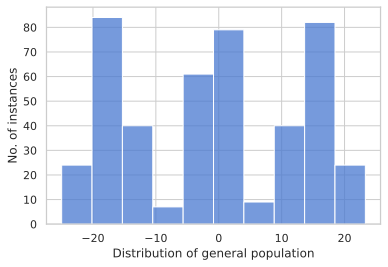

In [ ]:
hist = sns.histplot(dmesa.general_samples)

hist.set(xlabel='Distribution of general population', ylabel ='No. of instances', )
plt.show()

Boxplots for sample mean:

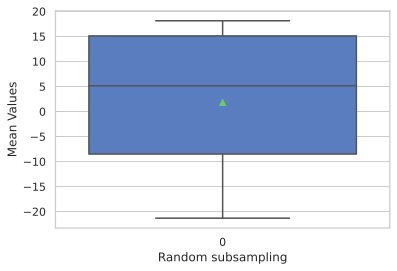

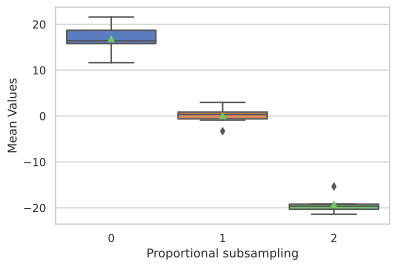

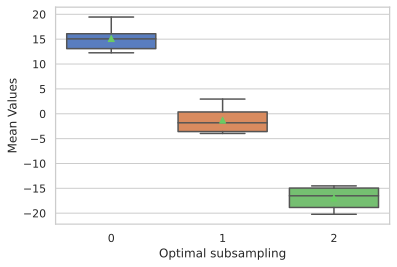

In [ ]:
rdm = dmesa.random_subsampling(size = 20)
prp = dmesa.proportional_subsampling(size = 20)
opt = dmesa.optimal_subsampling(size = 20)
plot1 = sns.boxplot(data = rdm, showmeans = True)
plot1.set(xlabel='Random subsampling', ylabel ='Mean Values')
plt.show()
plot2 = sns.boxplot(data = prp, showmeans = True)
plot2.set(xlabel='Proportional subsampling', ylabel ='Mean Values')
plt.show()
plot3 = sns.boxplot(data = opt, showmeans = True)
plot3.set(xlabel='Optimal subsampling', ylabel ='Mean Values')
plt.show()

In this case random subsampling does not give us a good idea of what is going on in the dataset, both proportional and optimal subsampling give us insight into radically different means with optimal subsampling again being this tiny bit more accurate

**General population with DIFFERENT means and DIFFERENT STDs of strata**  
Distribution histogram:

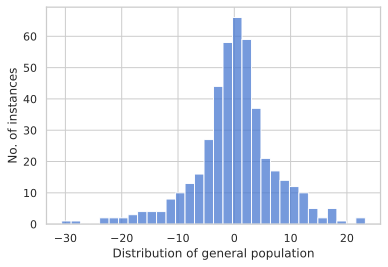

In [ ]:
hist = sns.histplot(emdsa.general_samples)

hist.set(xlabel='Distribution of general population', ylabel ='No. of instances')
plt.show()

Boxplots for sample mean:

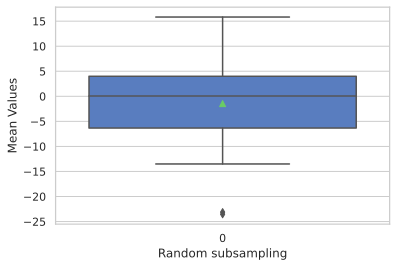

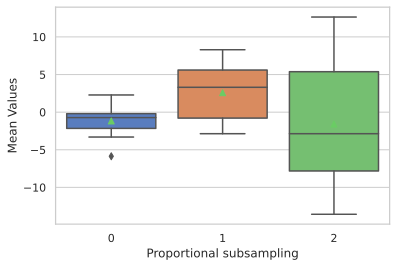

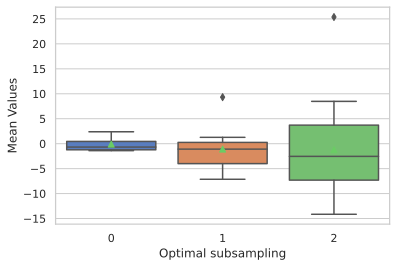

In [ ]:
rdm = emdsa.random_subsampling(size = 30)
prp = emdsa.proportional_subsampling(size = 30)
opt = emdsa.optimal_subsampling(size = 30)
plot1 = sns.boxplot(data = rdm, showmeans = True)
plot1.set(xlabel='Random subsampling', ylabel ='Mean Values')
plt.show()
plot2 = sns.boxplot(data = prp, showmeans = True)
plot2.set(xlabel='Proportional subsampling', ylabel ='Mean Values')
plt.show()
plot3 = sns.boxplot(data = opt, showmeans = True)
plot3.set(xlabel='Optimal subsampling', ylabel ='Mean Values')
plt.show()

This time again, random subsampling does quite an alright job when means do not differ that much, but obscures our vision on what is going on with the deviation. Proportional subsampling again shows us what we need to know while being slightly less accurate in its prediction than optimal subsampling

With the experiments conducted and statistics estimated we can generate these <b>conclusions</b>: 


*   Sample size seems to be a very important parameter to control. The bigger the sample size the better the subsampling does at estimating population means and standard deviations
*   Random subsampling seems to be the least efficient method each time, requiring higher sample size to correctly estimate the mean and standard deviation
*   Optimal subsampling seems to be more accurate than Proportional subsampling at estimating both parameters even in smaller sample sizes as clearly visible at each set of box plots above
*   Based on the insight from above i would suggest that a method of subsampling should be chosen according to the sample size it is possible to obtain. If we only can obtain proportionally small amount of samples Optimal Subsampling should be strived for. If, however we are able to choose a sufficiently large sample size, even random subsampling will eventually converge to correct values of mean and SD. In such cases it might be preferable to choose a method lighter on processing power such as random or proportional subsampling to optimal.









# Task 2



### Part 1
Using [this criteria](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/#:~:text=For%20the%20Pearson%20correlation%2C%20an,linear%20relationship%20between%20the%20variables.&text=If%20both%20variables%20tend%20to,represents%20the%20correlation%20slopes%20upward.), check whether there is a correlation between a brain size and intelligence for a dataset consisted both of men and women objects. Also check it for men and women subsamples separately.


### Part 2
Using $Chi^2$ criteria check whether there is a statistical difference between men's and women's choice of auto.  (Features `Sex` and `PreferCar`)


You can download dataset using the following:

In [ ]:
!pip install bds-courseware

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from bds_courseware import read_drive_dataset
from bds_courseware import HOMEWORK_DATASETS
brain_data = read_drive_dataset(*HOMEWORK_DATASETS['brain'])  # PART 1
cars_prefes_data = read_drive_dataset(*HOMEWORK_DATASETS['car_perfs'])  # PART 2

In [ ]:
brain_data.head()

,Gender,FSIQ,VIQ,PIQ,Weight,Height,MRI_Count
0,Female,133,132,124,118,64.5,816932
1,Male,140,150,124,�,72.5,1001121
2,Male,139,123,150,143,73.3,1038437
3,Male,133,129,128,172,68.8,965353
4,Female,137,132,134,147,65.0,951545


Some column names require further explanation. Here's a copy-paste from google to explain the meanings:

Full-Scale Intelligence Quotient (FSIQ) is a term coined for an individual's complete cognitive capacity. With regard to children, the Wechsler Intelligence Scale for Children (WISC) is the most commonly used test in helping measure a child's mental capacity.

Verbal Intelligence Quotient (VIQ) is a numerical measurement of your child's spoken language capabilities and limitations. It is used to gauge your child's ability to reason out and understand others through spoken words.

Performance Intelligence Quotient (PIQ) is a score resulting from a test that assesses your child's mental capacity in dealing with nonverbal skills. Usually, an IQ test has two major components: the verbal test and the performance test.

MRI counts stands for for number of MRI units, which corresponds to size of the image.

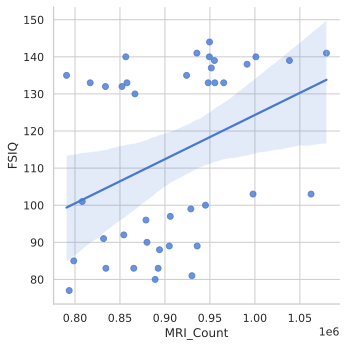

Pearson's coefficient of correlation for FSIQ : 0.35764096936905665


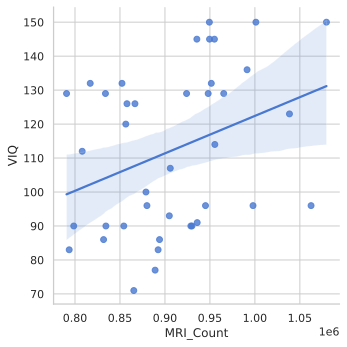

Pearson's coefficient of correlation for VIQ : 0.33747772802033543


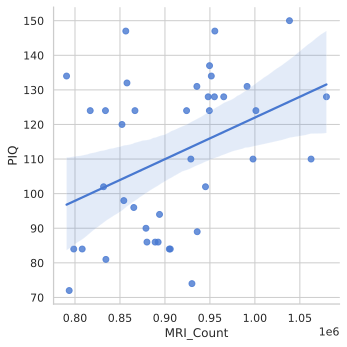

Pearson's coefficient of correlation for PIQ : 0.3868173150245029


In [ ]:
# lets see it on the scatterplot first
sns.set_theme(style='whitegrid', palette='muted')

plot = sns.lmplot(data=brain_data, x='MRI_Count', y='FSIQ')
plt.show()
print("Pearson's coefficient of correlation for FSIQ : " + str(st.pearsonr(x=brain_data['MRI_Count'], y=brain_data['FSIQ'])[0]))
plot2 = sns.lmplot(data=brain_data, x='MRI_Count', y='VIQ')
plt.show()
print("Pearson's coefficient of correlation for VIQ : " + str(st.pearsonr(x=brain_data['MRI_Count'], y=brain_data['VIQ'])[0]))
plot3 = sns.lmplot(data=brain_data, x='MRI_Count', y='PIQ')
plt.show()
print("Pearson's coefficient of correlation for PIQ : " + str(st.pearsonr(x=brain_data['MRI_Count'], y=brain_data['PIQ'])[0]))

There seems to be a moderately positive correlation between brain size and all 3 types of intelligence measurements, though not a strong one.
In the first scatterplot especially (Full-Scale Intelligence Quotient) we see as if there are two groups clearly visible. Let's investigate if that can be the gender. 

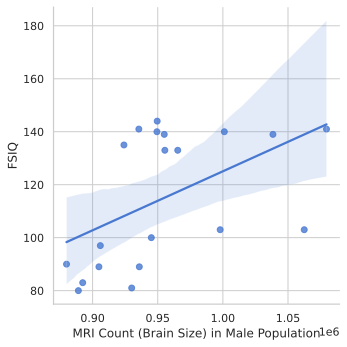

Pearson's coefficient of correlation for FSIQ for male population : 0.49836911041719256


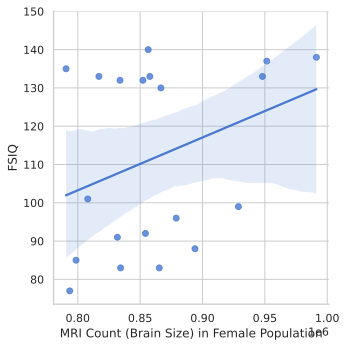

Pearson's coefficient of correlation for FSIQ for female population : 0.3256967004963704


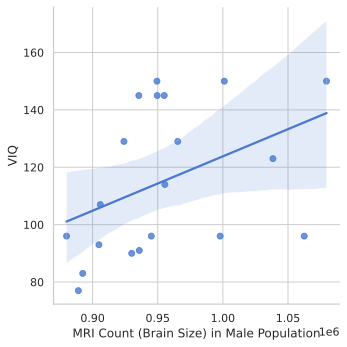

Pearson's coefficient of correlation for VIQ for male population : 0.4131049601428286


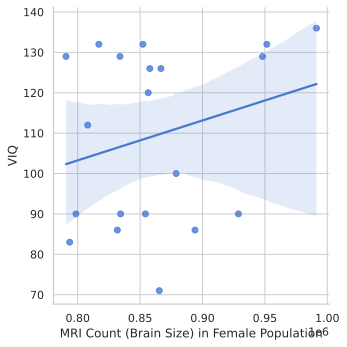

Pearson's coefficient of correlation for VIQ for female population : 0.2549328529614766


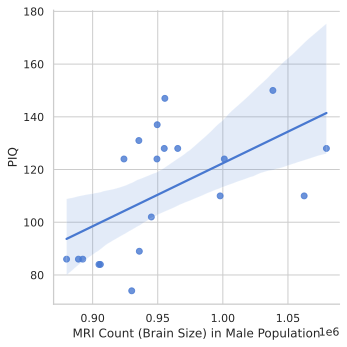

Pearson's coefficient of correlation for VIQ for male population : 0.4131049601428286


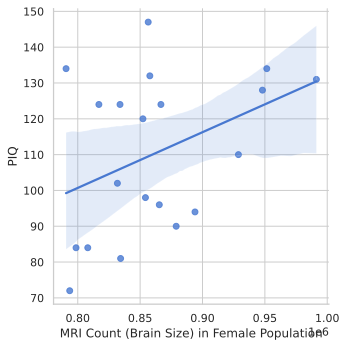

Pearson's coefficient of correlation for VIQ for female population : 0.2549328529614766


In [ ]:
sns.set_theme(style='whitegrid', palette='muted')
male_population = brain_data[brain_data['Gender']=='Male']
female_population = brain_data[brain_data['Gender']=='Female']

plot = sns.lmplot(data=male_population, x='MRI_Count', y='FSIQ')
plot.set(xlabel='MRI Count (Brain Size) in Male Population')
plt.show()
print("Pearson's coefficient of correlation for FSIQ for male population : " + str(st.pearsonr(x=male_population['MRI_Count'], y=male_population['FSIQ'])[0]))
plot = sns.lmplot(data=female_population, x='MRI_Count', y='FSIQ')
plot.set(xlabel='MRI Count (Brain Size) in Female Population')
plt.show()
print("Pearson's coefficient of correlation for FSIQ for female population : " + str(st.pearsonr(x=female_population['MRI_Count'], y=female_population['FSIQ'])[0]))
plot = sns.lmplot(data=male_population, x='MRI_Count', y='VIQ')
plot.set(xlabel='MRI Count (Brain Size) in Male Population')
plt.show()
print("Pearson's coefficient of correlation for VIQ for male population : " + str(st.pearsonr(x=male_population['MRI_Count'], y=male_population['VIQ'])[0]))
plot = sns.lmplot(data=female_population, x='MRI_Count', y='VIQ')
plot.set(xlabel='MRI Count (Brain Size) in Female Population')
plt.show()
print("Pearson's coefficient of correlation for VIQ for female population : " + str(st.pearsonr(x=female_population['MRI_Count'], y=female_population['VIQ'])[0]))
plot = sns.lmplot(data=male_population, x='MRI_Count', y='PIQ')
plot.set(xlabel='MRI Count (Brain Size) in Male Population')
plt.show()
print("Pearson's coefficient of correlation for VIQ for male population : " + str(st.pearsonr(x=male_population['MRI_Count'], y=male_population['VIQ'])[0]))
plot = sns.lmplot(data=female_population, x='MRI_Count', y='PIQ')
plot.set(xlabel='MRI Count (Brain Size) in Female Population')
plt.show()
print("Pearson's coefficient of correlation for VIQ for female population : " + str(st.pearsonr(x=female_population['MRI_Count'], y=female_population['VIQ'])[0]))

It seems that 'intelligence' seems to correlate with brain size a bit stronger for males than for females in this particular set of data. Pearson's coefficients also seem toconfirm it. It is perculiar that there seems to be a gap in FSIQ values roughly from 100 to 130. This gap does not seem to stem from differences in gender.

# Task 2 part 2

In [ ]:
cars_prefes_data.head()

,ID,Age,Sex,LicYr,LicMth,ActCar,Kids5,Kids6,PreferCar,Car15K,...,Reliable,Perform,Fuel,Safety,AC/PS,Park,Room,Doors,Prestige,Colour
0,110,18,2,0,2,3,2,2,2,2,...,4,3,3,3,3,3,3,3,3,2
1,111,25,1,8,0,1,2,2,1,1,...,4,4,4,4,3,4,4,2,3,3
2,112,63,2,46,0,3,2,2,3,2,...,3,3,3,3,3,3,3,3,3,3
3,113,51,1,35,0,3,2,2,2,2,...,3,3,3,4,3,3,3,3,1,3
4,114,19,1,2,0,2,2,2,2,1,...,3,4,3,3,2,3,3,2,3,3


H0: "Car Preference" is independent of variable "Sex"

First we take the columns we're interested in forms of a contingency table. 
The genders are encoded by numbers 1,2 hiding from researcher which gender is which, decreasing potential bias stemming from researcher's own beliefs. Preference is encoded by numbers 1,2,3,4

In [ ]:
cars_crosstab = pd.crosstab(cars_prefes_data['Sex'],
                            cars_prefes_data['PreferCar'],
                            margins = False)
cars_crosstab

PreferCar,1,2,3,4
Sex,,,,
1,43,75,26,6
2,25,61,47,17


In [ ]:
stat, p, dof, expected = st.chi2_contingency(cars_crosstab)


array([[34. , 68. , 36.5, 11.5],
       [34. , 68. , 36.5, 11.5]])

In [ ]:
prob = 0.95
critical = st.chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
  print("Variables are dependent - H0 rejected")
else:
  print("Variables are independent - failed to reject H0")

probability=0.950, critical=7.815, stat=17.508
Variables are dependent - H0 rejected


Null hypothesis has been rejected - there seems to be a dependance between gender and car preference

# Task 3

You can find and download a dataset there:
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016


1) For any country (you are free to choose any of the presented) 
 *  Visualize a feature **suicides_no** considering other features: **sex**, **age** (or **generation**) and year;
 *  Check whether there is statistical difference for suicide number between these groups: men / women. If it is found, can we claim that people of certain sex are more prone to suicides or do we need additional information?

2) For 2016: divide countries into 3-4 groups according to the values of the **gdp_per_capita** feature (use statistical characteristics to determine how to divide the data into groups), check if the suicides / 100k pop indicator differs in these groups. Do not forget that for each country you have several values and they need to be aggregated or checked for each group separately.

In [ ]:
uploaded = files.upload()

Saving suicide.csv to suicide.csv


In [ ]:
suicide = pd.read_csv(io.BytesIO(uploaded['suicide.csv']), header=0)

In [ ]:
suicide.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [ ]:
suicide.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [ ]:
suicide.columns

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')

In [ ]:
suicide.dtypes

country                object
year                    int64
sex                    object
age                    object
suicides_no             int64
population              int64
suicides/100k pop     float64
country-year           object
HDI for year          float64
 gdp_for_year ($)      object
gdp_per_capita ($)      int64
generation             object
dtype: object

In [ ]:
poland_suicide = suicide[suicide['country'] == 'Poland']

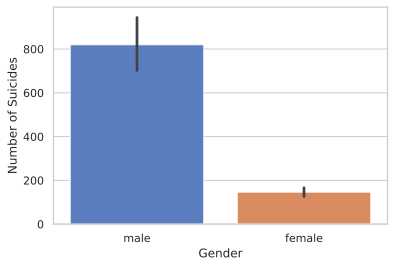

In [ ]:
sns.set_theme(style='whitegrid', palette='muted')

plot = sns.barplot(data=poland_suicide, x='sex', y='suicides_no')
plot.set(xlabel = 'Gender', ylabel = 'Number of Suicides')
plt.show()

There is a huge difference in numbers of suicides by gender. Let's investigate the correlation using a t-test:

In [ ]:
st.ttest_ind(poland_suicide['suicides_no'][poland_suicide['sex'] == 'male'],
             poland_suicide['suicides_no'][poland_suicide['sex'] == 'female'])

t_statistic, p_value = st.ttest_ind(poland_suicide['suicides_no'][poland_suicide['sex'] == 'male'], poland_suicide['suicides_no'][poland_suicide['sex'] == 'female'])

# Check the p-value to determine statistical significance. Assuming p_value of 0.08
if p_value < 0.05:
    print("There is a statistically significant difference between the number of suicides for men and women.")
else:
    print("There is no statistically significant difference between the number of suicides for men and women.")

print("p_value is equal to " + str(p_value))

There is a statistically significant difference between the number of suicides for men and women.
p_value is equal to 1.3017471592420186e-23


In this particular case I would argue that we can make a claim that men in poland are more prone to suicide than women. For one the p-value of the t-test is incredibly small suggesting it's very unlikely that the difference occured by chance. Another argument besides the data itself would be knowledge of different societal expectations towards gender in this particular society where it is not seen as acceptable for a man to show vunerability and seek help.

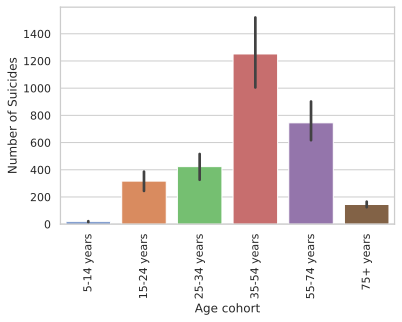

In [ ]:
plot = sns.barplot(data=poland_suicide, x='age', y='suicides_no', order = ['5-14 years','15-24 years' , '25-34 years', '35-54 years', '55-74 years', '75+ years' ])
plot.set(xlabel = 'Age cohort', ylabel = 'Number of Suicides')
plt.xticks(rotation = 90)
plt.show()

I've decided to check the number of suicides by age cohort instead of generation. American 'generation' labels have little to no use in central and eastern europe and localized labels such as these should be avoided. For example what people in Poland would call baby boomers would be around 20 years younger than American boomers.

It seems that the pattern here might follow a bit skewed normal distribution, with majority of people commiting suicides in age 35-54. It is worth noting that first 3 categories span only 9 years where starting at age 35 each bin covers about 19 years. Therefore we couldn't claim that people of ages 55-74 are almost twice as prone to suicide than 25-34 year olds because their cohort might simply be larger. Suicide numbers divided by population would be a much better indicator and will be investigated further.

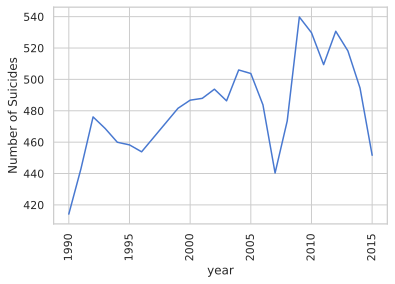

In [ ]:
plot = sns.lineplot(data=poland_suicide, x='year', y='suicides_no', err_style = None)
plot.set(xlabel = 'year', ylabel = 'Number of Suicides')
plt.xticks(rotation = 90)
plt.show()

Seems that the relationship between number of suicides in time is not linear.
It might be worth checking if this correlates to times of economical struggle as indicated by changing gdp per capita

# Task 3 part 2 

selecting  only 2016 and grouping by country

In [ ]:
suicide_2016 = suicide[suicide['year'] == 2016]


Let's divide the countries by the GDP per capita into four percentile ranges

In [ ]:
suicide_2016 = suicide_2016.assign(percentile=pd.qcut(suicide_2016['gdp_per_capita ($)'], q=4, labels=['25th Percentile', '50th Percentile', '75th Percentile', '100th Percentile']))

In [ ]:
suiper100 = suicide_2016.groupby('percentile')['suicides/100k pop'].mean().reset_index(name='Mean suicides per 100k population')

plot = px.bar(suiper100, x= 'percentile' , y= 'Mean suicides per 100k population', title = 'Distribution of mean suicides through percentiles of countries wealth' )
plot.show()

Turns out that suicides per 100k population differ quite substantially between the percentiles. Surprisingly the highest suicide ratio is between the 50th and 75th percentile, meaning that it is most prevalent in moderately wealthy countries. It is quite suprirising that mean values for poorest and wealthiest cohort don't seem to be very different.